# Import Relevant Libraries

In [250]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import textwrap
from sklearn.model_selection import train_test_split
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error


# Load and Read File

In [251]:
file_path = '/Users/aylaakhtari/Desktop/Caffe_Sales.xlsx'
# Load the Excel file
df = pd.read_excel(file_path, sheet_name='Coffee Sales')
#print(df.keys()) 

# Examine Dataset

In [252]:
# Check the structure of the dataset
print("\nDataset information:")
df.info()
print("\nSummary statistics for numerical columns:")
print(df.describe())
print(df.columns)


Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3636 entries, 0 to 3635
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   coffee_name  3636 non-null   object        
 1   cash_type    3636 non-null   object        
 2   card         3636 non-null   object        
 3   datetime     3636 non-null   object        
 4   date         3636 non-null   datetime64[ns]
 5   year         3636 non-null   int64         
 6   month        3636 non-null   int64         
 7   Quter        3636 non-null   object        
 8   money        3636 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(5)
memory usage: 255.8+ KB

Summary statistics for numerical columns:
                                date         year        month        money
count                           3636  3636.000000  3636.000000  3636.000000
mean   2024-09-30 11:56:02.376237568  2024.259351     6

# BAR PLOT
Displays average value of the money for each Coffee Type
Useful for comparing the average sales or revenue for different coffee types

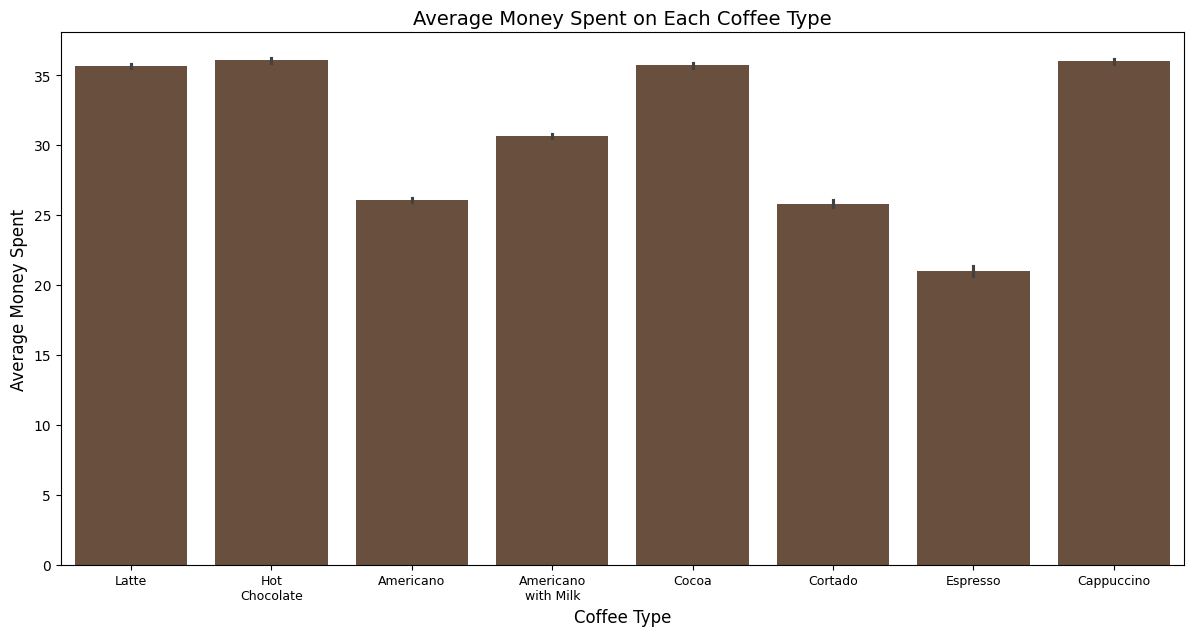

In [253]:

# Visualize the distribution of coffee types purchased

wrapped_labels = [textwrap.fill(label, width=10) for label in df['coffee_name']] # Wrap coffee names for better readability
plt.figure(figsize=(12, 6))
sns.barplot(x=wrapped_labels, y='money', data=df, color ='#6F4E37') #sienna or #6F4E37 for coffee color
plt.xticks(fontsize=9)
plt.tight_layout()
plt.title('Average Money Spent on Each Coffee Type', fontsize=14)
plt.xlabel('Coffee Type', fontsize=12)
plt.ylabel('Average Money Spent', fontsize=12)
plt.show()

# COUNT PLOT
Displays the frequency of each coffee type purchased
USeful for displaying how many times each coffee type was purchased (which drinks are favored)

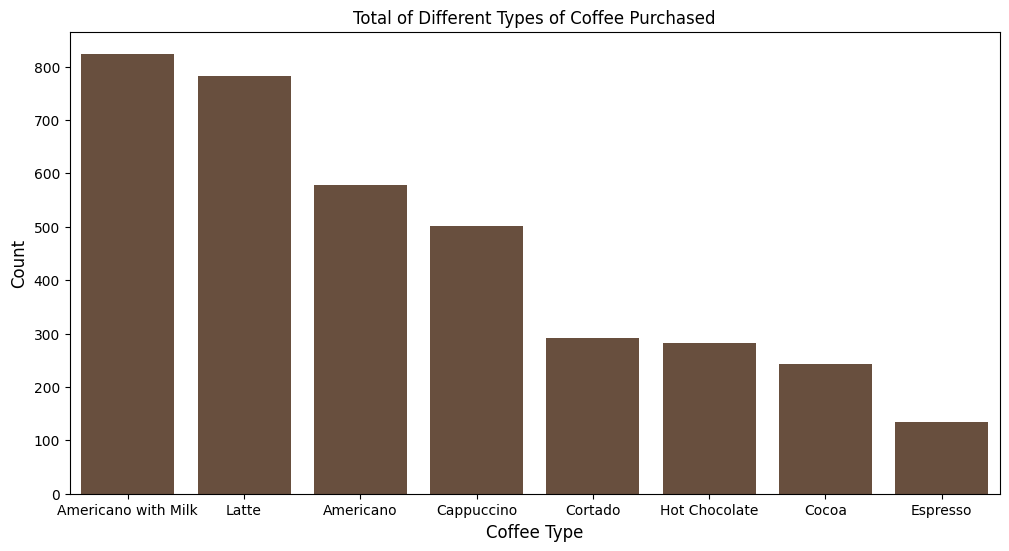

In [254]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='coffee_name', order=df['coffee_name'].value_counts().index, color ='#6F4E37')
plt.title('Total of Different Types of Coffee Purchased')
plt.xlabel('Coffee Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

__Custom Palette for Visualization:__

custom_palette = [
    '#6F4E37',  # Coffee Brown
    #'#A0522D',  # Sienna
    #'#D2B48C',  # Tan
    #'#8B4513',  # Saddle Brown
    #'#C19A6B',  # Light Brown
    '#FFE4C4',  # Bisque (Neutral)
    '#DEB887',  # Burlywood
    '#F5DEB3',  # Wheat
    '#D2691E',  # Chocolate
    '#CD853F',  # Peru
    '#B8860B',  # Dark Goldenrod
    '#E3DAC9'   # Almond (Neutral)
]

# Visualization of distribution of coffee types purchased by quarter

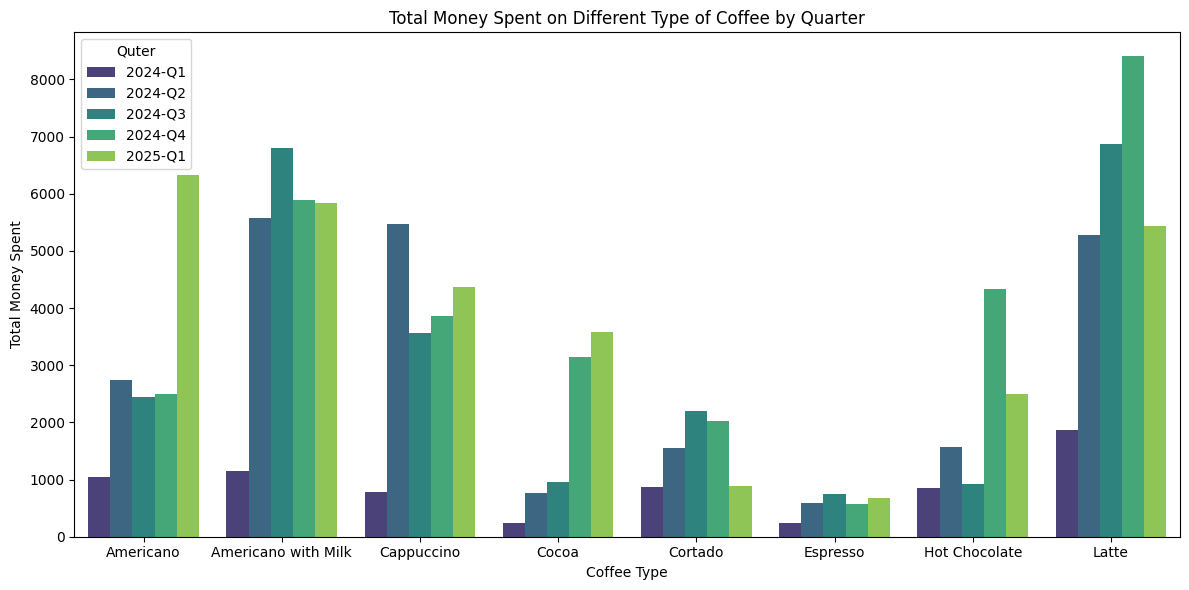

In [255]:
# Group by coffee type and quarter
# Note: Quater column is mispelled in the original dataset. (Quter = Quarter)
quarterly_totals = df.groupby(['coffee_name', 'Quter'])['money'].sum().reset_index()

#print(quarterly_totals)

plt.figure(figsize=(12,6))
sns.barplot(data=quarterly_totals, x='coffee_name', y='money', hue='Quter', palette='viridis', dodge=True)
plt.title('Total Money Spent on Different Type of Coffee by Quarter')
plt.xlabel('Coffee Type')
plt.ylabel('Total Money Spent')
#plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Stacked Bar Chart of Total Coffee Sales by Quarter and Type
The stacked bar chart shows the total sales for each coffee type broken down by quarter. 
It helps highlight which coffee types performed better in different parts of the year and gives a quick visual of seasonal or quarterly trends.
The use of color makes it easy to compare relative contribution of each quarter to the overall yearly total per coffee type.

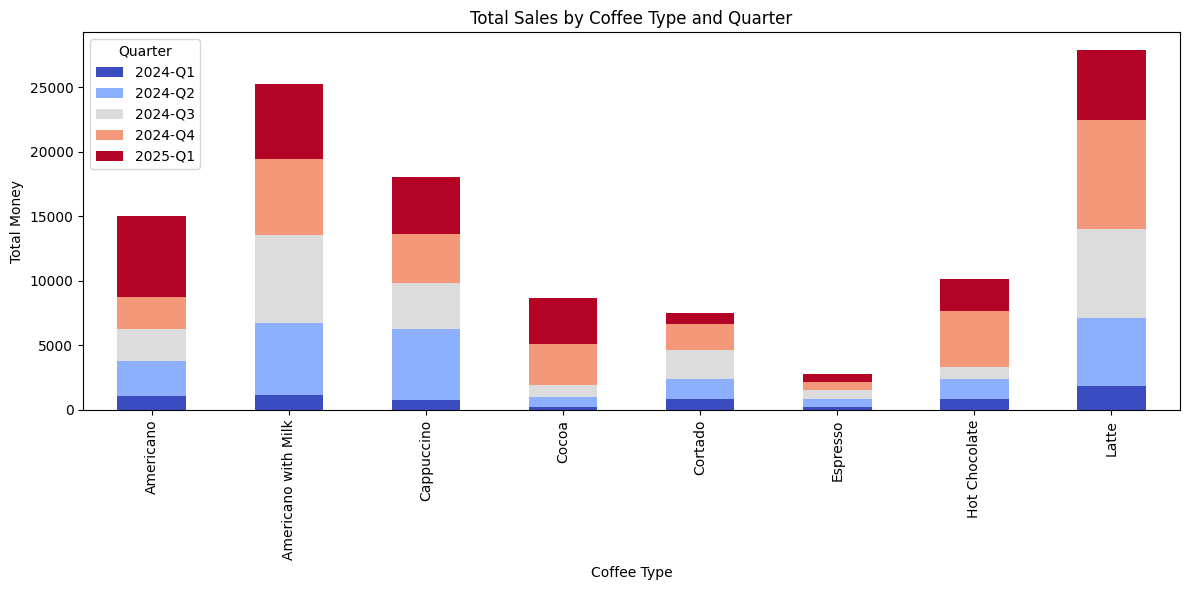

In [277]:
pivot_table = quarterly_totals.pivot(index='coffee_name', columns='Quter', values='money')
pivot_table = pivot_table.plot(kind='bar', stacked = True, colormap = 'coolwarm', figsize=(12, 6))
plt.title('Total Sales by Coffee Type and Quarter')
plt.xlabel('Coffee Type')
plt.ylabel('Total Money')
plt.legend(title='Quarter')
plt.tight_layout()
plt.show()

# Line Graph - Total Sales of Each Coffee Type (13 month Timeframe)

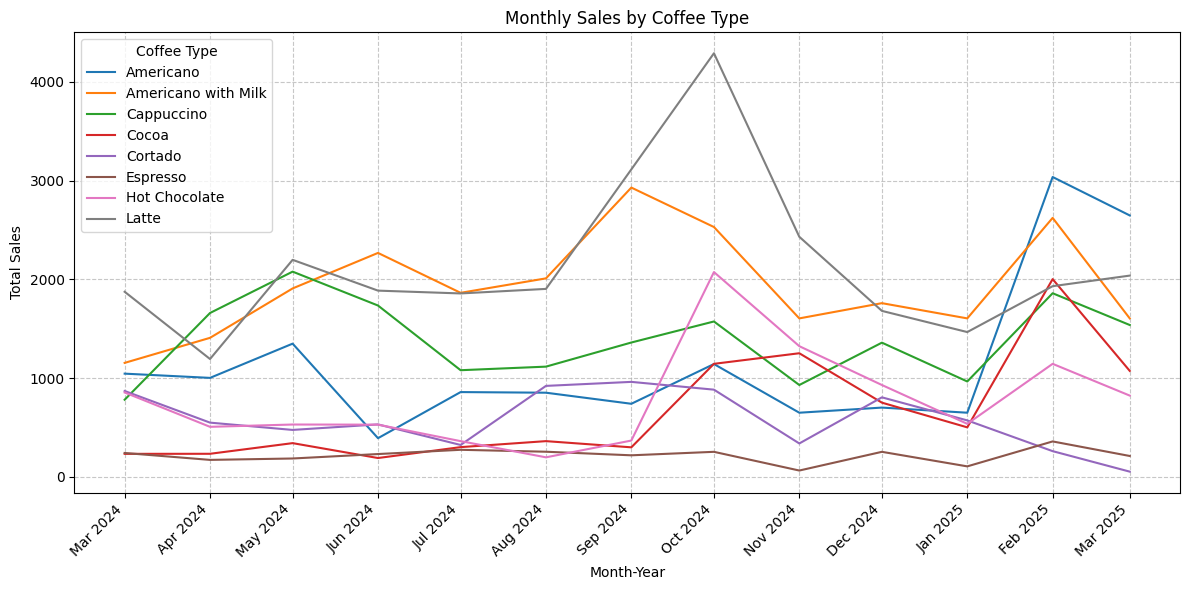

count    3636.000000
mean       31.746859
std         4.919926
min        18.120000
25%        27.920000
50%        32.820000
75%        35.760000
max        40.000000
Name: money, dtype: float64


In [247]:
# Create a year-month column for analysis
df['month_year'] = pd.to_datetime(df['month_year'])
# Group by coffee type and month to calculate total sales
monthly_totals = df.groupby(['coffee_name', 'month_year'])['money'].sum().reset_index()

#Create the line plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_totals, x='month_year', y='money', hue='coffee_name', palette='tab10')

# Add labels and title
plt.title('Monthly Sales by Coffee Type')
plt.xlabel('Month-Year')
plt.ylabel('Total Sales')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45, ha='right')
plt.legend(title='Coffee Type')
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()
print(df['money'].describe())


# Preprocess Data

In [213]:
# Fill missing values in categorical columns with the mode
df['money'] = df['money'].replace('[\$,]', '', regex=True).astype(float) # Convert 'money' column to numeric
categorical_columns = df.select_dtypes(include=['object']).columns

# Convert 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'], errors ='coerce') 
df['month_date'] = df['date'].dt.to_period('M').dt.to_timestamp()  # Create a new column for month-year

# Aggregate monthly coffee purchases
monthly_sales = df.groupby(['month_date', 'coffee_name'])['money'].sum().reset_index()

# Pivot the data for visualization
monthly_sales_pivot = monthly_sales.pivot(index = 'month_date', columns = 'coffee_name', values = 'money').fillna(0)


# Verify that there are no missing values left
print("\nMissing values after preprocessing:")
print(df.isnull().sum())

# Display the first few rows of the preprocessed dataset
print("\nFirst few rows and column names of the preprocessed dataset:")
print(df.head())
print(df.columns)


Missing values after preprocessing:
coffee_name    0
cash_type      0
card           0
datetime       0
date           0
year           0
month          0
Quter          0
money          0
month_date     0
dtype: int64

First few rows and column names of the preprocessed dataset:
     coffee_name cash_type                 card  datetime       date  year  \
0          Latte      card  ANON-0000-0000-0001  10:15:51 2024-03-01  2024   
1  Hot Chocolate      card  ANON-0000-0000-0002  12:19:23 2024-03-01  2024   
2  Hot Chocolate      card  ANON-0000-0000-0002  12:20:18 2024-03-01  2024   
3      Americano      card  ANON-0000-0000-0003  13:46:33 2024-03-01  2024   
4          Latte      card  ANON-0000-0000-0004  13:48:15 2024-03-01  2024   

   month    Quter  money month_date  
0      3  2024-Q1   38.7 2024-03-01  
1      3  2024-Q1   38.7 2024-03-01  
2      3  2024-Q1   38.7 2024-03-01  
3      3  2024-Q1   28.9 2024-03-01  
4      3  2024-Q1   38.7 2024-03-01  
Index(['coffee_name',

# Set Training, Testing, Future Sets


In [219]:
# Define train/test split
train_end = '2024-09-30'
test_start = '2024-10-01'
test_end = '2025-03-31'
# forecast_horizon = 12
future_index= pd.date_range(start='2025-04-01', periods= 12, freq='MS')

# Initialize lists to store results
results = []
mae_list, rmse_list, mape_list, coffee_names = [], [], [], []
forecast_dfs = {
    'Prophet': pd.DataFrame(index=future_index),
    'SARIMAX': pd.DataFrame(index=future_index),
    'Exponential Smoothing': pd.DataFrame(index=future_index)
}



# Forecasting Monthly Coffee Sales by Model (Per Coffee Type)

__Three Time Series models were used: Prophet, Sarimax, and Exponential Smoothing models.__

This section loops through each coffee type and applies three forecasting models: Prophet, SARIMA, and Exponential Smoothing. 

For each model, I trained it on data up to September 2024, testing on actuals from October 2024 to March 2025, and forecasted from April to August 2025. Negative values were clipper to 0. The mean absolute error (MAE) was also calculated for each model to compare performance.

A plot is generated showed the actual training and test data along with forecast from each model, allowing for a visual comparison of model performance by coffee type.

/var/folders/w0/06xv66v16cq818hls1xp3fp40000gn/T/ipykernel_59103/768377424.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts['y'] = ts['y'].clip(lower=0)
13:08:55 - cmdstanpy - INFO - Chain [1] start processing
13:08:55 - cmdstanpy - INFO - Chain [1] done processing
/Users/aylaakhtari/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/aylaakhtari/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/aylaakhtari/Library/Pytho

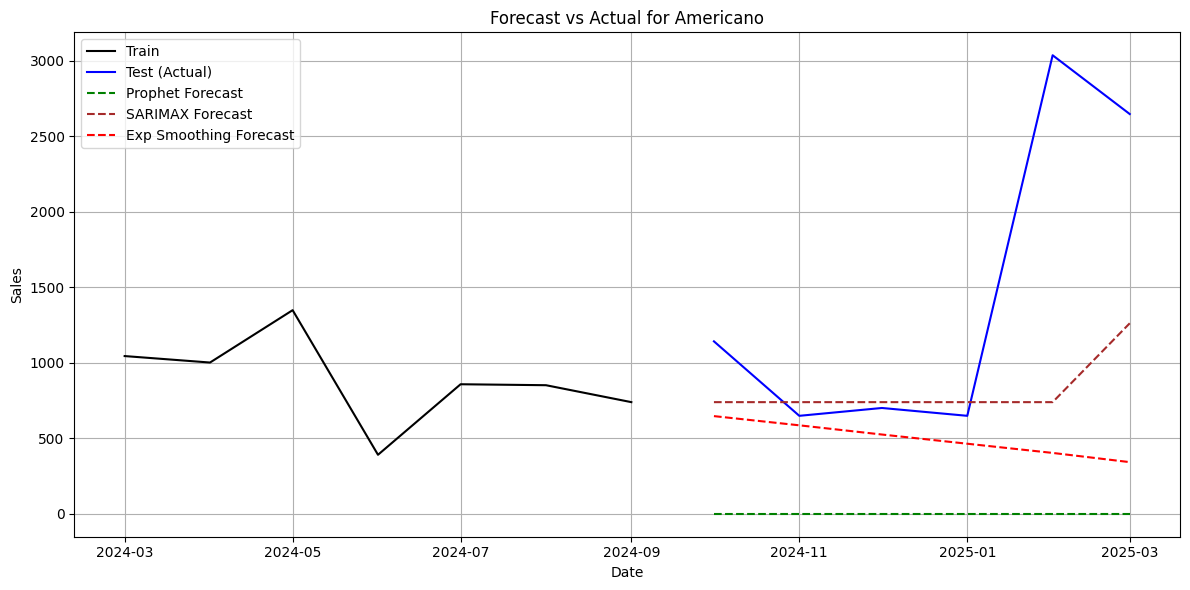

/var/folders/w0/06xv66v16cq818hls1xp3fp40000gn/T/ipykernel_59103/768377424.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts['y'] = ts['y'].clip(lower=0)
13:08:55 - cmdstanpy - INFO - Chain [1] start processing
13:08:56 - cmdstanpy - INFO - Chain [1] done processing
/Users/aylaakhtari/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/aylaakhtari/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/aylaakhtari/Library/Pytho

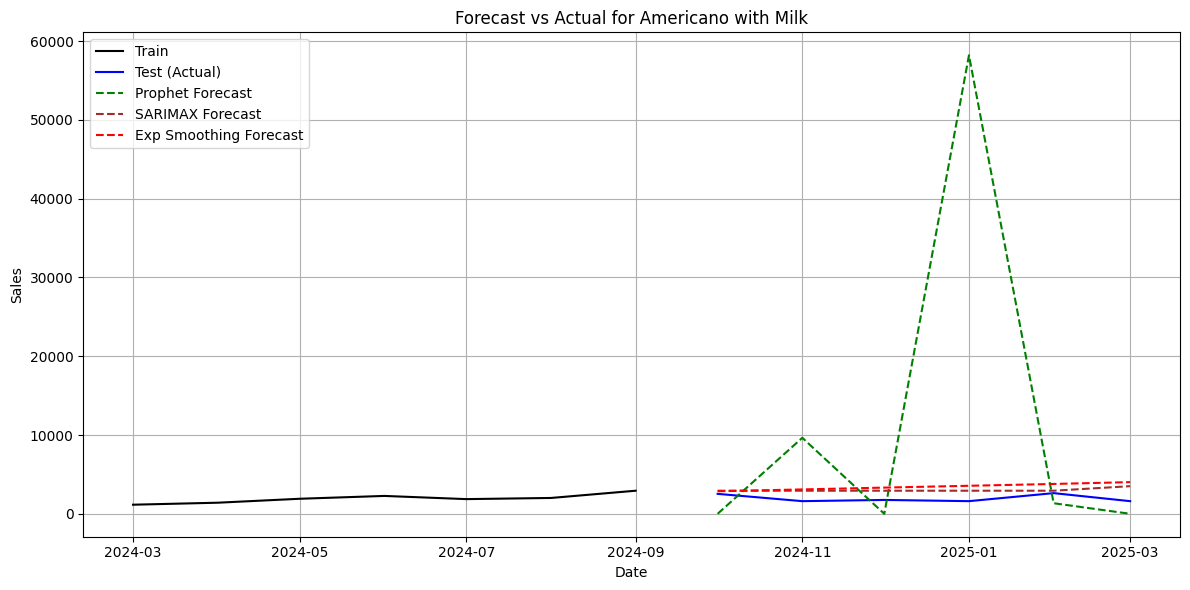

/var/folders/w0/06xv66v16cq818hls1xp3fp40000gn/T/ipykernel_59103/768377424.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts['y'] = ts['y'].clip(lower=0)
13:08:56 - cmdstanpy - INFO - Chain [1] start processing
13:08:56 - cmdstanpy - INFO - Chain [1] done processing
/Users/aylaakhtari/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/aylaakhtari/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/aylaakhtari/Library/Pytho

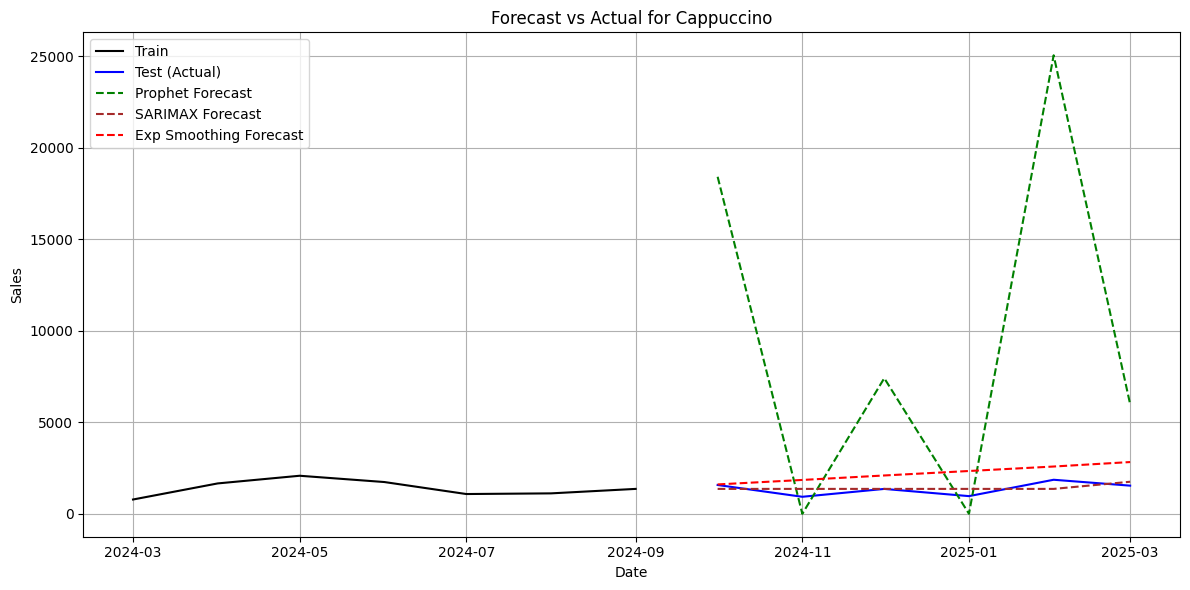

/var/folders/w0/06xv66v16cq818hls1xp3fp40000gn/T/ipykernel_59103/768377424.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts['y'] = ts['y'].clip(lower=0)
13:08:56 - cmdstanpy - INFO - Chain [1] start processing
13:08:58 - cmdstanpy - INFO - Chain [1] done processing
/Users/aylaakhtari/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/aylaakhtari/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/aylaakhtari/Library/Pytho

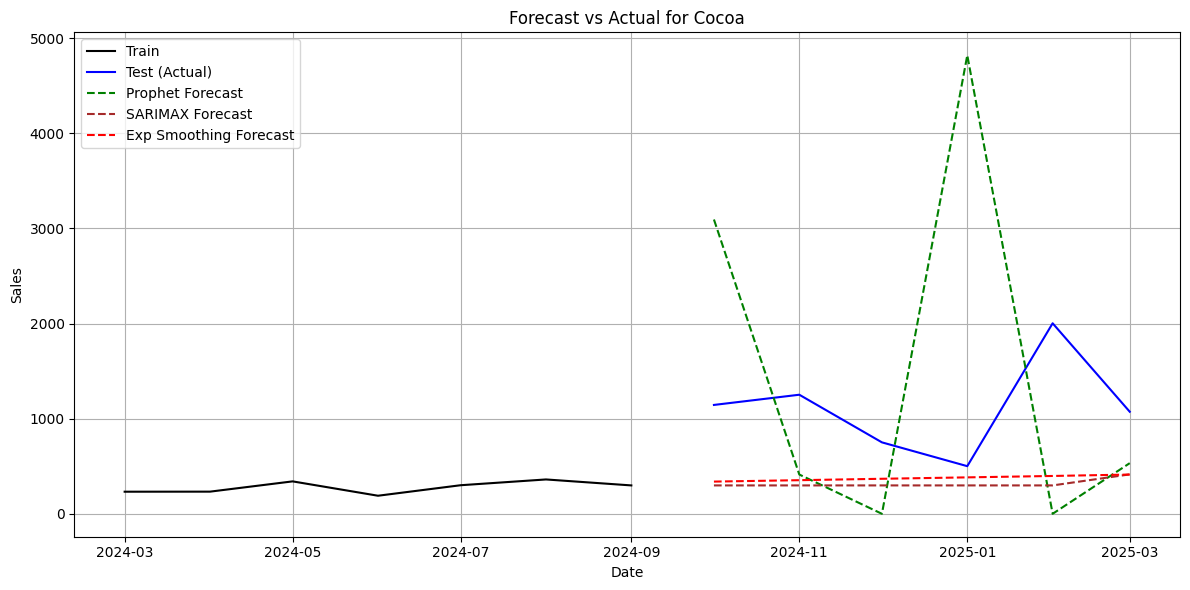

/var/folders/w0/06xv66v16cq818hls1xp3fp40000gn/T/ipykernel_59103/768377424.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts['y'] = ts['y'].clip(lower=0)
13:08:58 - cmdstanpy - INFO - Chain [1] start processing
13:08:58 - cmdstanpy - INFO - Chain [1] done processing
/Users/aylaakhtari/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/aylaakhtari/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/aylaakhtari/Library/Pytho

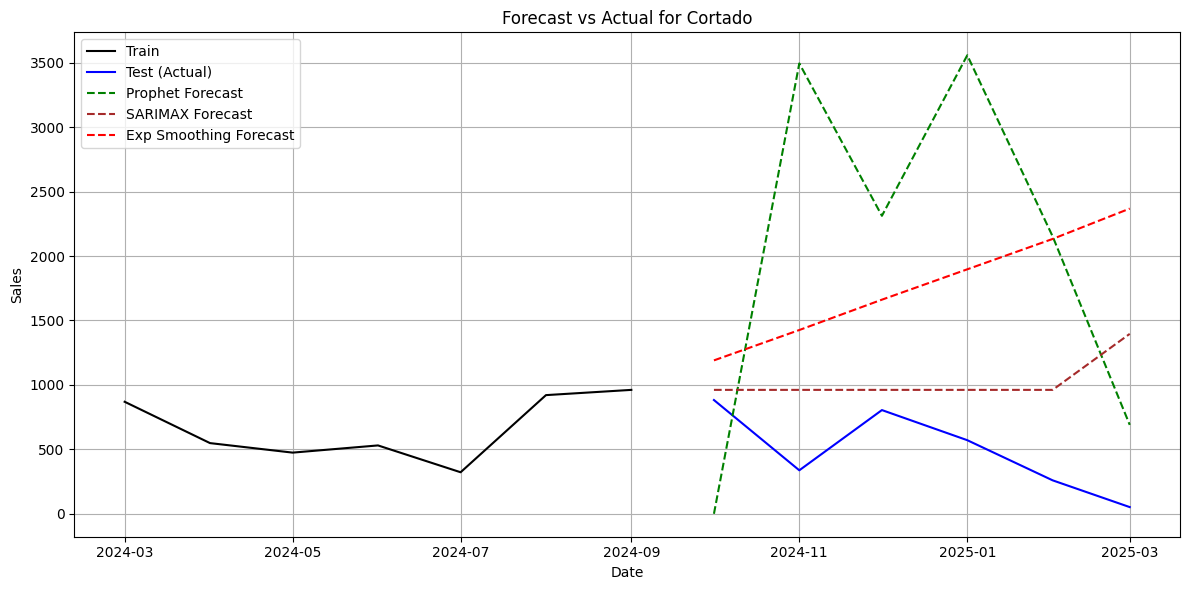

/var/folders/w0/06xv66v16cq818hls1xp3fp40000gn/T/ipykernel_59103/768377424.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts['y'] = ts['y'].clip(lower=0)
13:08:59 - cmdstanpy - INFO - Chain [1] start processing
13:08:59 - cmdstanpy - INFO - Chain [1] done processing
/Users/aylaakhtari/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/aylaakhtari/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/aylaakhtari/Library/Pytho

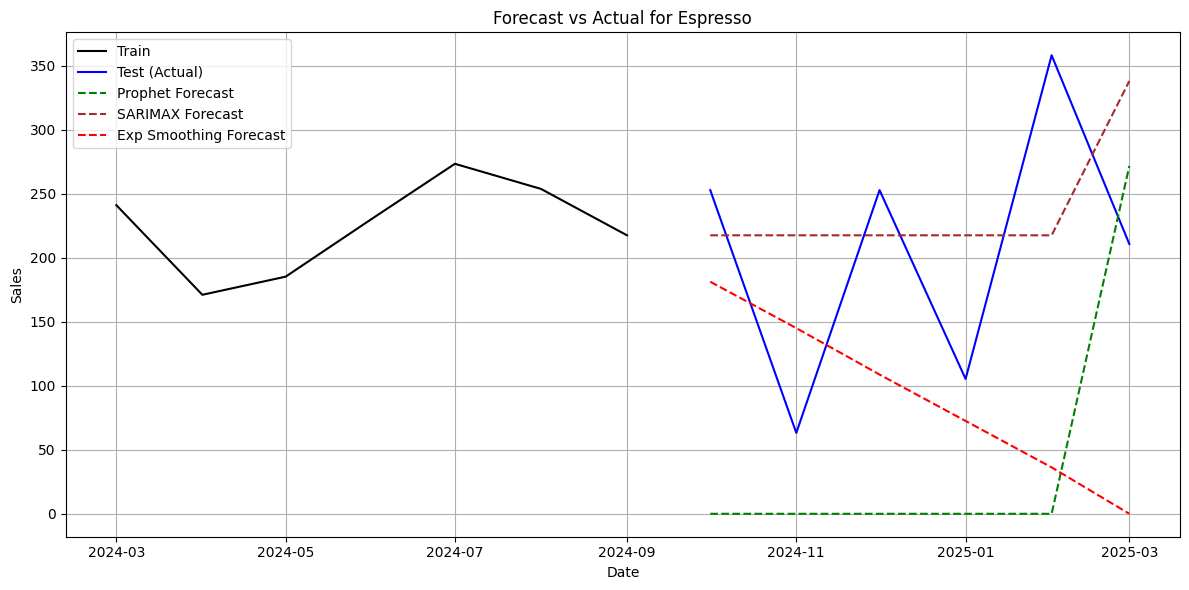

/var/folders/w0/06xv66v16cq818hls1xp3fp40000gn/T/ipykernel_59103/768377424.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts['y'] = ts['y'].clip(lower=0)
13:08:59 - cmdstanpy - INFO - Chain [1] start processing
13:08:59 - cmdstanpy - INFO - Chain [1] done processing
/Users/aylaakhtari/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/aylaakhtari/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/aylaakhtari/Library/Pytho

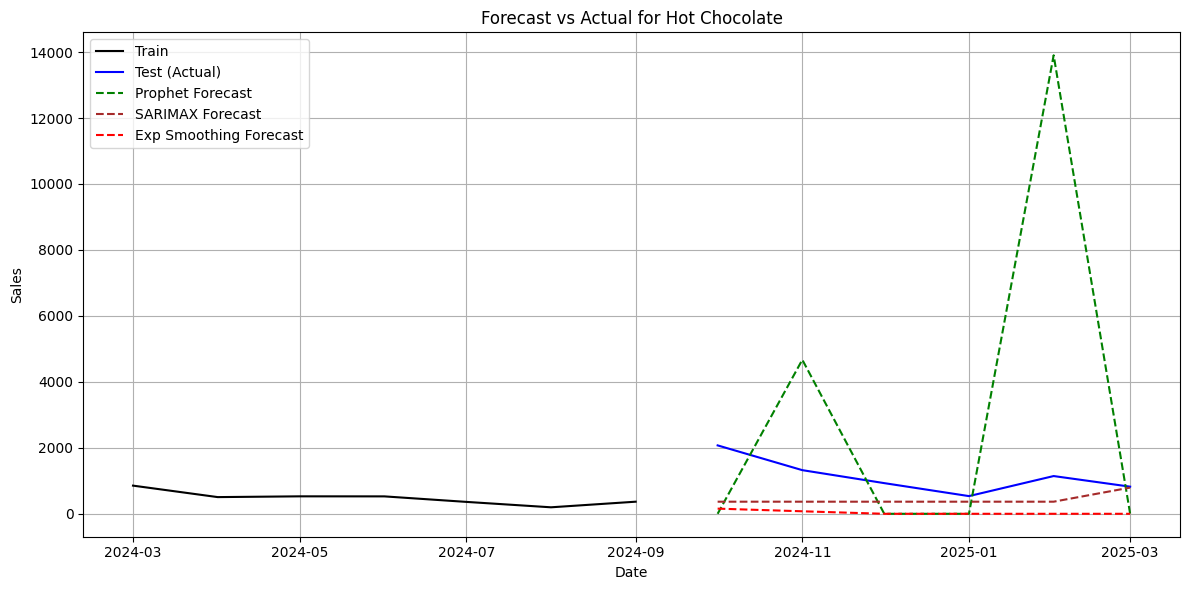

/var/folders/w0/06xv66v16cq818hls1xp3fp40000gn/T/ipykernel_59103/768377424.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts['y'] = ts['y'].clip(lower=0)
13:08:59 - cmdstanpy - INFO - Chain [1] start processing
13:08:59 - cmdstanpy - INFO - Chain [1] done processing
/Users/aylaakhtari/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/aylaakhtari/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/aylaakhtari/Library/Pytho

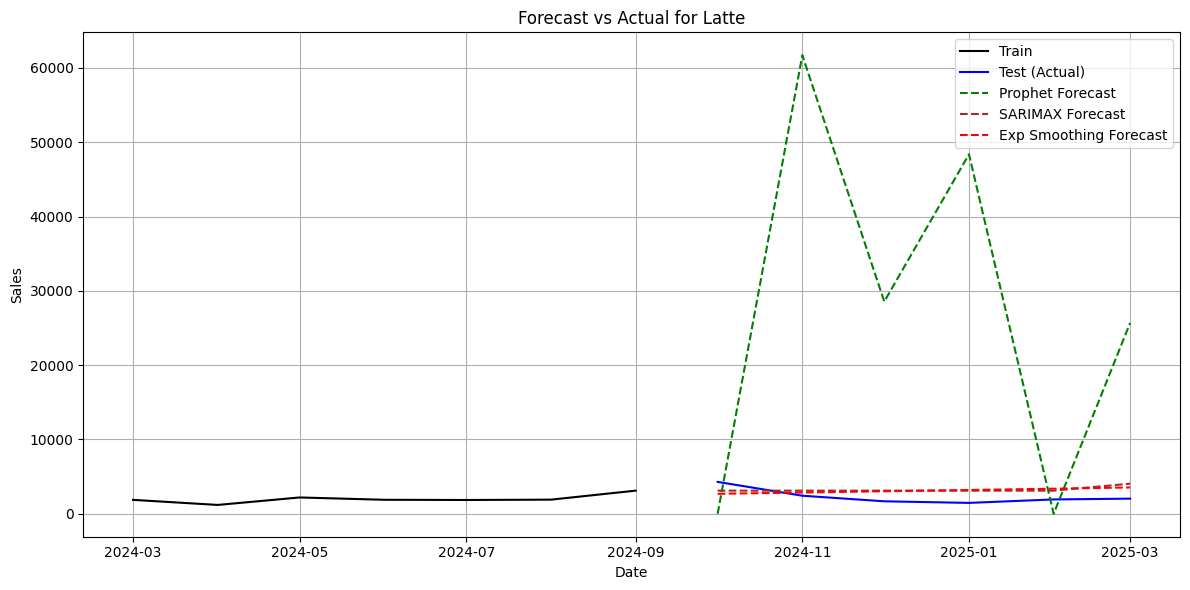

In [ ]:
for coffee in monthly_sales_pivot.columns:
    ts = monthly_sales_pivot[[coffee]]
    ts.columns = ['y']
    ts['y'] = ts['y'].clip(lower=0)
    ts.index = pd.to_datetime(ts.index)

    # Check if the time series has enough data points
    if ts['y'].nunique() <= 1 or ts['y'].isnull().all():
        print(f"Skipping {coffee} due to insufficient data or constant values.")
        continue

    # Split into train and test
    train = ts[ts.index <= train_end]
    test = ts[(ts.index >= test_start) & (ts.index <= test_end)]

    # Check if train and test sets are not empty
    if train.empty or test.empty:
        print(f"Skipping {coffee} due to missing training/testing set.")
        continue

    # PROPHET MODEL
    prophet_df = train.reset_index().rename(columns={'month_date': 'ds', 'y': 'y'})
    prophet_train = prophet_df[prophet_df['ds'] <= train_end]
    prophet_model = Prophet(yearly_seasonality=True)
    prophet_model.fit(prophet_train)
    future = prophet_model.make_future_dataframe(periods=len(test) + len(future_index), freq='MS')
    forecast = prophet_model.predict(future)
    prophet_forecast_test = forecast.set_index('ds').loc[test.index, 'yhat'].clip(lower=0) 
    prophet_future = forecast.set_index('ds').loc[future_index, 'yhat'].clip(lower=0)
    forecast_dfs['Prophet'][coffee] = prophet_future


    # SARIMAX MODEL
    sarimax_model = SARIMAX(train['y'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    sarimax_fit = sarimax_model.fit(disp=False)
    sarimax_forecast_test = sarimax_fit.forecast(steps=len(test)).clip(lower=0)
    sarimax_future = sarimax_fit.forecast(steps=len(future_index)).clip(lower=0)
    forecast_dfs['SARIMAX'][coffee] = sarimax_future.values


    # EXPONENTIAL SMOOTHING MODEL
    try:
        exp_model = ExponentialSmoothing(train['y'], trend='add', seasonal=None, seasonal_periods=12)
        exp_fit = exp_model.fit()
        exp_forecast_test = exp_fit.forecast(len(test)).clip(lower=0)
        exp_future = exp_fit.forecast(len(future_index)).clip(lower=0)
        forecast_dfs['Exponential Smoothing'][coffee] = exp_future.values

        # Calculate and store metrics for each model
        results.append({
            'Coffee': coffee,
            'MAE (Prophet)': mean_absolute_error(test['y'], prophet_forecast_test),
            'MAE (SARIMAX)': mean_absolute_error(test['y'], sarimax_forecast_test),
            'MAE (ExpSmoothing)': mean_absolute_error(test['y'], exp_forecast_test),
        })
    except ValueError as e:
        # Handle potential errors in Exponential Smoothing
        print(f"Skipping {coffee} due to error in Exponential Smoothing: {e}")
        forecast_dfs['ExpSmoothing'][coffee] = np.nan
        results.append({
            'Coffee': coffee,
            'MAE (Prophet)': mean_absolute_error(test['y'], prophet_forecast_test),
            'MAE (SARIMAX)': mean_absolute_error(test['y'], sarimax_forecast_test),
            'MAE (ExpSmoothing)': np.nan,
        })
    # Plot actuals vs. forecast for the test period
    plt.figure(figsize=(12, 6))
    plt.plot(train.index, train['y'], label='Train', color='black')
    plt.plot(test.index, test['y'], label='Test (Actual)', color='blue')
    plt.plot(test.index, prophet_forecast_test, label='Prophet Forecast', linestyle='--', color='green')
    plt.plot(test.index, sarimax_forecast_test, label='SARIMAX Forecast', linestyle='--', color='brown')
    plt.plot(test.index, exp_forecast_test, label='Exp Smoothing Forecast', linestyle='--', color='red')
    plt.title(f'Forecast vs Actual for {coffee}')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
            





# Evaluation Tables

In [286]:
# Print evaluation results
eval_df = pd.DataFrame(results)
print("\nModel Comparison (MAE):")
print(eval_df.sort_values(by='MAE (Prophet)', ascending=True))


Model Comparison (MAE):
                 Coffee  MAE (Prophet)  MAE (SARIMAX)  MAE (ExpSmoothing)
5              Espresso     182.160308     100.813343          143.750001
13             Espresso     182.160308     100.813343          143.750001
0             Americano    1471.066667     717.693290          976.432763
8             Americano    1471.066667     717.693290          976.432763
3                 Cocoa    1733.546354     802.809990          744.982161
11                Cocoa    1733.546354     802.809990          744.982161
4               Cortado    1844.008820     549.306703         1294.608387
12              Cortado    1844.008820     549.306703         1294.608387
6         Hot Chocolate    3411.327545     700.293298         1099.622905
14        Hot Chocolate    3411.327545     700.293298         1099.622905
2            Cappuccino    8737.279038     292.001699          845.060011
10           Cappuccino    8737.279038     292.001699          845.060011
1   Americano

# Plot Different Forecast Models
__Prophet:__

This model handled seasonality and trends fairly well for most of the coffee types, but it produced flat lines at the start of the forecast and sometimes generated unrealistic spikes shortly after. It also struggled with irregular or sparse patterns, especially when there wasn’t enough seasonality in the data.

__SARIMA:__

This model worked better with stable and seasonal time series. However, the flat forecasts and small shifts show that SARIMA often undercuts when data doesn’t clearly follow seasonal cycles. It also requires parameter tuning, and without optimization, results can be overly conservative.

__Exponential Smoothing:__

This model shows smooth, steadily increasing lines for all coffee types. It is an oversimplified prediction model that does not capture fluctuations or seasonality. It performed well when there are consistent trends but failed on shorter and erratic series. It sometimes raised error if the data didn’t include enough full seasonal cycles, especially when there was sparse data. Some forecasts even dropped below zero, which was corrected manually. 


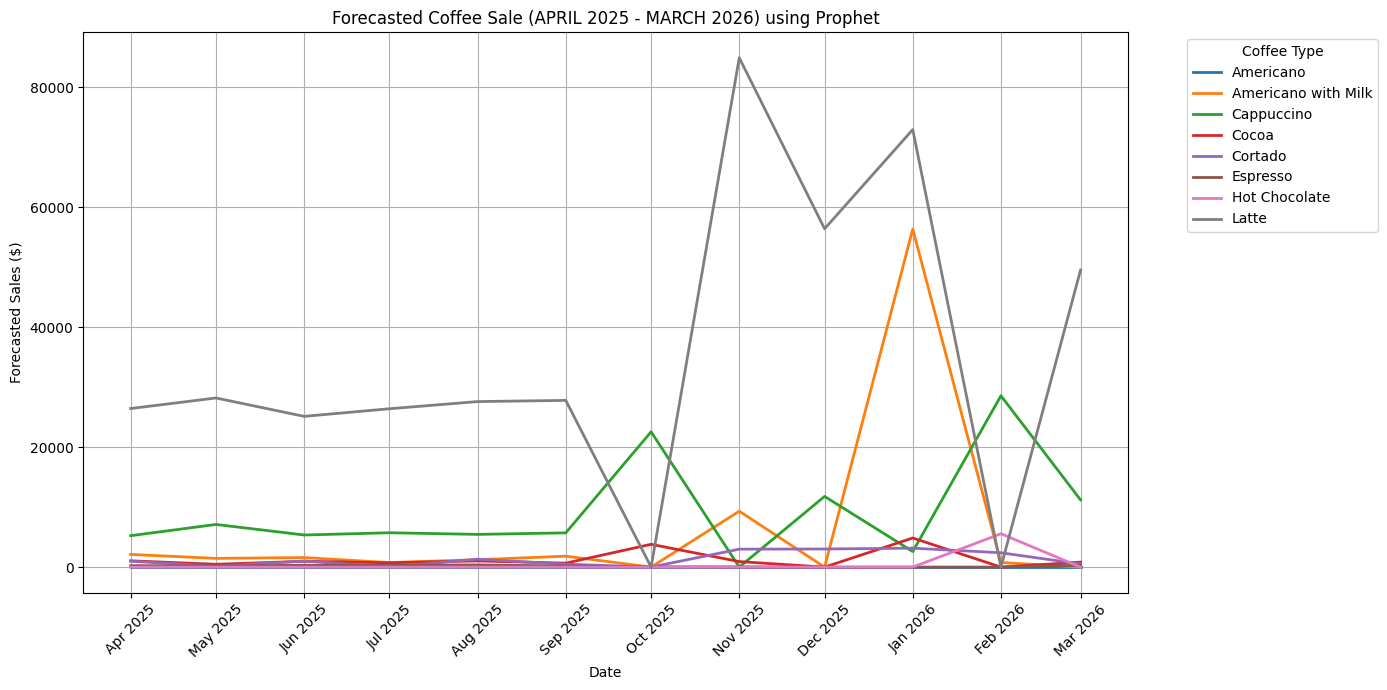

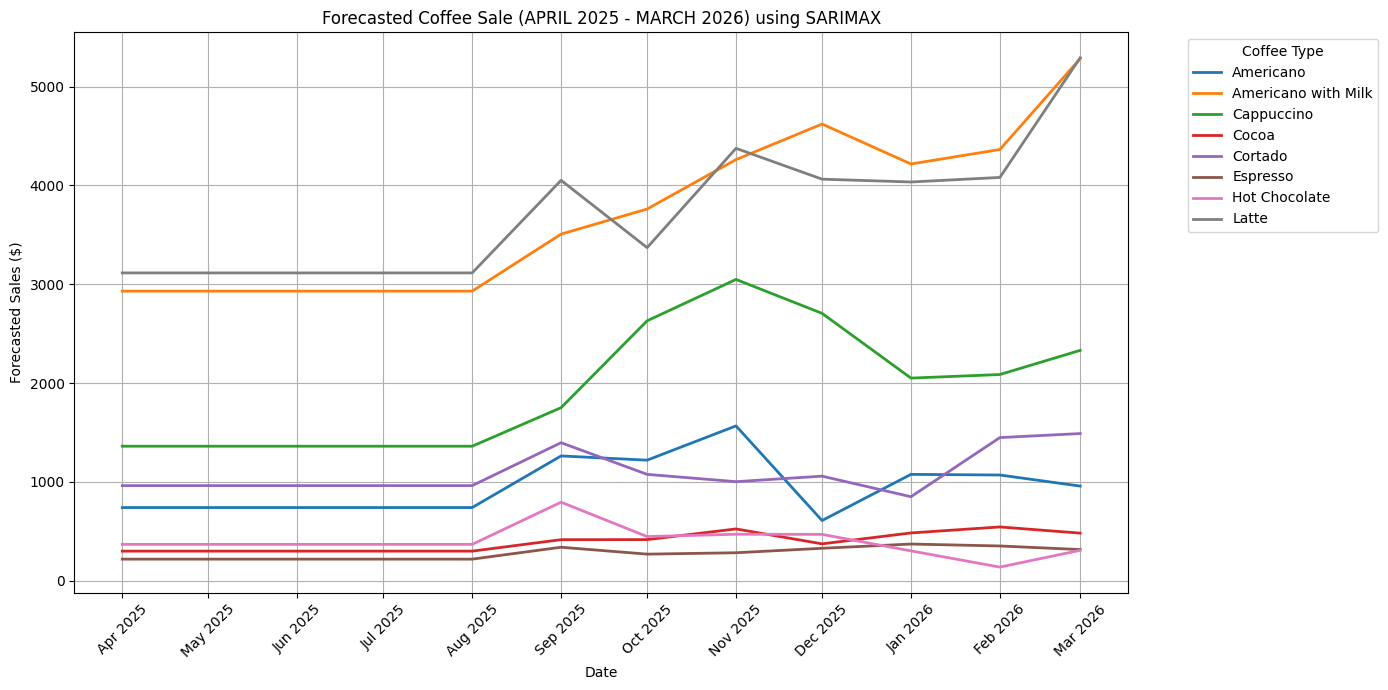

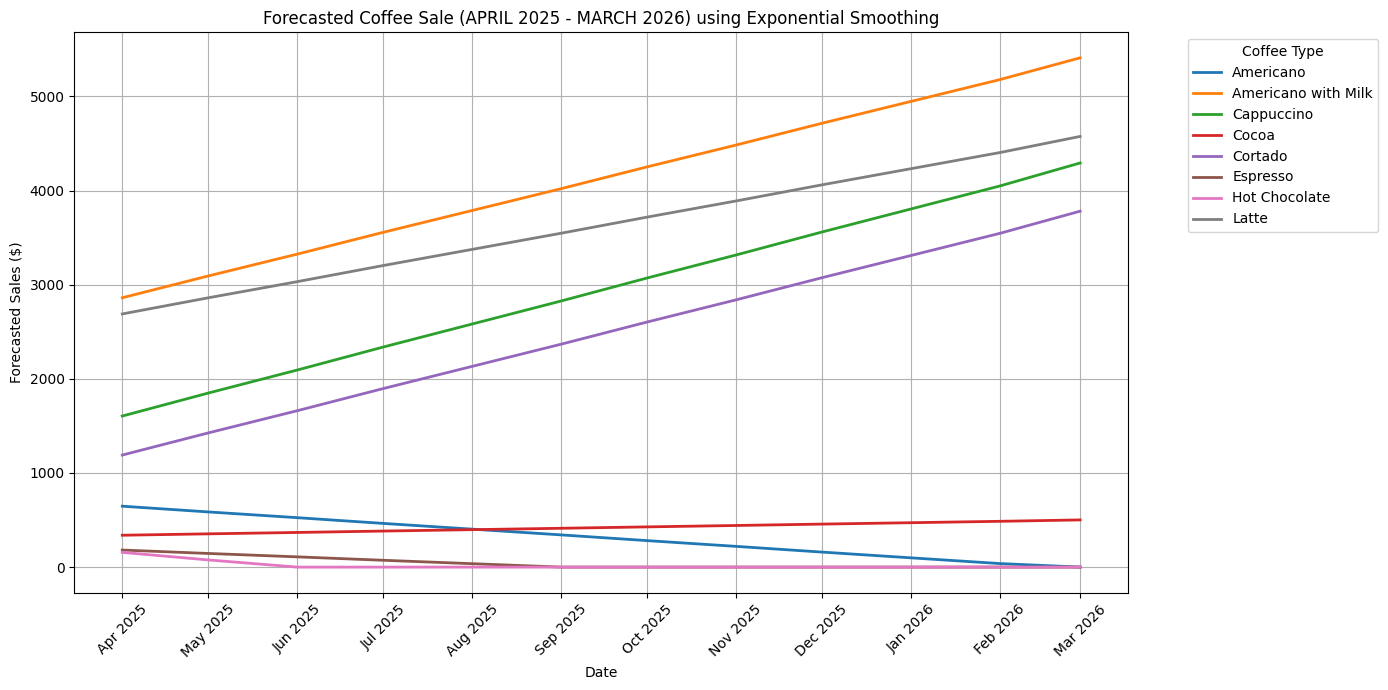

In [287]:
# For loop to plot the forecasted sales for each model
for model_name, forecast_df in forecast_dfs.items():
    plt.figure(figsize=(14, 7))
    for coffee in forecast_df.columns:
        plt.plot(forecast_df.index, forecast_df[coffee], label=coffee, linewidth=2)
    plt.title(f"Forecasted Coffee Sale (APRIL 2025 - MARCH 2026) using {model_name}")
    plt.xlabel('Date')
    plt.ylabel('Forecasted Sales ($)')
    plt.xticks(ticks = future_index, labels=[d.strftime('%b %Y') for d in future_index], rotation=45)
    plt.legend(title='Coffee Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    